# Run experiments to "Validate Mathis model at Edge and Core Scale"

## Set up your FABRIC environment


In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Bastion Username,vinita_p_0000073925
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Bastion Username,vinita_p_0000073925
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


In [2]:
!chmod 600 {fablib.get_bastion_key_filename()}
!chmod 600 {fablib.get_default_slice_private_key_file()}

## Get slice details

Put your slice name and the number of endpoints in the following cell:

In [3]:
n_endpoints = 10
slice_name="bottleneck-" + str(n_endpoints) + '-test'

Then, load your slice details into the environment.slice = fablib.new_slice(name=slice_name)

In [4]:
slice = fablib.get_slice(name=slice_name)

In [5]:
sender_nodes = [slice.get_node(name='sender-' + str(i))  for i in range(n_endpoints)]
receiver_nodes = [slice.get_node(name='receiver-' + str(i))  for i in range(n_endpoints)]

In [6]:
router_node = slice.get_node(name='router')
router_ingress_iface = router_node.get_interface(network_name = "link-sender")
router_egress_iface  = router_node.get_interface(network_name = "link-receiver")
router_egress_name = router_egress_iface.get_device_name()

## Setup the scripts and modules

First, we will upload all the scripts we need to analyze the results for this experiment. This needs to be done only once before start of experiment.

In [25]:
for n in sender_nodes:
    n.upload_file('process_cwn_file.py','process_cwn_file.py')
    n.upload_file('process_iperf_normal.py','process_iperf_normal.py')
    n.upload_file('mathis_new_sender.py','mathis_new_sender.py')
    n.upload_file("cwn.sh", "cwn.sh")

Also we need sklearn to process the downloaded files, so install the library in the environment.This needs to be done only once before start of experiment.

In [16]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 34.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 35.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Generate flows

### Set experiment parameters

>delay, cca, test_duration, num_servers, flows

delay is the delay to be set at the receiver (=20 ms for this experiment)

cca is the congestion control algorithm (reno for this experiment)

Vary below parameters only:

num_servers is the number of ports to be opened on each receiver. For core scale we are opening 10 ports and for edge scale we are opening 1 port.

test_duration is the time for which to send the iperf3 flows.

flows is the number of parallel flows to be send from each port.

For example, to send 1000 flows set num_servers=10 and flows=10. This will send 100 flows from each of the 10 senders.

interval is to set the interval time in seconds between periodic bandwidth, jitter, and loss reports from iperf3 (=0.01 sec)

In [7]:
cca="reno"
delay=20
test_duration=900
num_servers=10
flows=1
interval=1

### Get queue statistics on the router before experiment

In [17]:
router_node.execute("tc -p -s -d -j qdisc show dev "+router_egress_name +" >tc_before.txt")

('', '')

In [18]:
router_node.execute("tail --lines=10 tc_before.txt")

            "limit": 26214400
        },
        "bytes": 827600397591,
        "packets": 546650204,
        "drops": 579320,
        "overlimits": 0,
        "requeues": 34215125,
        "backlog": 0,
        "qlen": 0
    } ]


('            "limit": 26214400\n        },\n        "bytes": 827600397591,\n        "packets": 546650204,\n        "drops": 579320,\n        "overlimits": 0,\n        "requeues": 34215125,\n        "backlog": 0,\n        "qlen": 0\n    } ]\n',
 '')

## Remove existing result files from the hosts

In [19]:
for n in receiver_nodes:
    n.execute("rm -f ./*")

for n in sender_nodes:
    n.execute("rm -f sender*")
    n.execute("rm -f data*")
    n.execute("rm -f packet*")
    n.execute("rm -f output*")

Check if the files are removed from the senders and receivers

In [20]:
for n in sender_nodes:
    n.execute("ls")

cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src
cwn.sh
examples
mathis_new_sender.py
process_cwn_file.py
process_iperf_normal.py
src


In [37]:
for n in receiver_nodes:
    n.execute("ls")

### Set delay on the receiver

> Values: 20ms, 100ms, 200ms

Now set up delay on the receiver interface:

First delete any existing queue (don't worry if there is an error, it means there was not!)

In [38]:
for n in receiver_nodes:
    receiver_inf=n.get_interface(network_name= "link-receiver")
    receiver_inf_name = receiver_inf.get_device_name()
    n.execute("sudo tc qdisc del dev " + receiver_inf_name + " root netem")
    n.execute("sudo tc qdisc add dev " + receiver_inf_name + " root netem delay " + str(delay) +"ms limit 1000000")
    

### Start parallel servers on the receivers

In this, the base_port is the starting address of port number

Now start the `iperf3` flows:

In [21]:
base_port=50000
for i, n in enumerate(receiver_nodes):
    n.execute("sudo killall iperf3")
    for k in range (1,num_servers+1): 
        server_port=base_port+k
        report_file=str(server_port)+"-server.dat"
        n.execute_thread("iperf3 -s -p "+str(server_port)+" -D --logfile "+report_file)

In [ ]:
#check files in all receiver
for n in receiver_nodes:
    n.execute("ls")

### Start parallel clients on the senders

In this, the base_port is the starting address of port number on the receiver


In [22]:
import time
base_port=50000
                                  
for i, n in enumerate(sender_nodes):
    n.execute("sudo killall iperf3")
    
    for k in range (0,num_servers):
        server_port=base_port+k+1
        report_file="sender-10.10.2.1"+str(i)+"-"+str(server_port)+"-"+str(test_duration)+"-"+cca+".txt"
        n.execute_thread("iperf3 -c 10.10.2.1"+str(i)+ " -p "+str(server_port)+ " -t "+str(test_duration)+ " -C "+cca+" -P "+str(flows)+ " -i "+str(interval)+" --format k &>"+report_file+ " &")
    time.sleep(5)
    n.execute_thread(f'chmod +x cwn.sh && bash cwn.sh 10.10.2.1'+str(i))
                                       
time.sleep(test_duration+60)              

 iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
  iperf3: no process found
 

In [ ]:
#check files on all the senders
for n in sender_nodes:
    n.execute("ls")
    

In [ ]:
sender_nodes[9].execute("tail --lines=10 sender-10.10.2.19-50001-1800-reno.txt")

### Get queue statistics on the router after experiment

In [8]:
router_node.execute("tc -p -s -d -j qdisc show dev "+router_egress_name +" >tc_after.txt")

('', '')

## Analyze the results

Calculate sum of bandwidth, square of sum of bandwidth, count of flows and jfi:

Calculate packet drop rate

In [9]:
#To get packet dropped:
(drop_before,err_drop_before)=router_node.execute("tail --lines=10 tc_before.txt| grep '\"drops\":' | awk '{print $2}' |cut -d ',' -f1")

#To get packets sent
(sent_before,err_sent_before)=router_node.execute("tail --lines=10 tc_before.txt| grep '\"packets\":' | awk '{print $2}' |cut -d ',' -f1")

#To get packet dropped:
(drop_after,err_drop_after)=router_node.execute("tail --lines=10 tc_after.txt| grep '\"drops\":' | awk '{print $2}' |cut -d ',' -f1")

#To get packets sent
(sent_after, err_sent_after)=router_node.execute("tail --lines=10 tc_after.txt| grep '\"packets\":' | awk '{print $2}' |cut -d ',' -f1")

#Calculate packet drop rate:

dropped=int(drop_after)-int(drop_before)

sent=int(sent_after)-int(sent_before)
drop_rate=float(dropped)/float(sent)

print("packet drop before running experiment: "+ str(drop_before))
print("packet sent before running experiment: " + str(sent_before))
print("packet drop after running experiment: "+ str(drop_after))
print("packet sent after  running experiment: " + str(sent_after))
print("packet drop rate: " + str(drop_rate))


579320
546650204
593842
626059715
packet drop before running experiment: 579320

packet sent before running experiment: 546650204

packet drop after running experiment: 593842

packet sent after  running experiment: 626059715

packet drop rate: 0.00018287481961701035


Run the data processing scripts on each sender to get packet loss, congestion window halving events and rtt from iperf3 and ss output.

In [10]:
for i,n in enumerate(sender_nodes):
    n.execute_thread(f'chmod +x process_cwn_file.py && python3 process_cwn_file.py '+str(i) )
    n.execute_thread(f'chmod +x process_iperf_normal.py && python3 process_iperf_normal.py '+str(i)+\
                                     " "+str(num_servers)+" "+str(test_duration)+" "+cca+" "+str(flows))



Run mathis_sender.py script on each sender to get packet loss rate and cwnd halving rate of each flow and save the output to packet_loss_iperf(i).csv file

In [11]:
import time
time.sleep(300)
for i,n in enumerate(sender_nodes):
    n.execute('chmod +x mathis_new_sender.py && python3 mathis_new_sender.py '+str(i)+\
                                      " "+str(num_servers)+" "+cca+" "+str(dropped)+" "+str(sent)+" "+str(interval)+" "+str(test_duration))

argument: 1 value: 0
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 value: 1
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 value: 2
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 value: 3
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 value: 4
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 value: 5
argument: 2 value: 10
argument: 3 value: reno
argument: 4 value: 14522
argument: 5 value: 79409511
argument: 6 value: 1
argument: 7 value: 900
argument: 1 valu

Get JFI by calculating total bandwidth, sum of sq of bandwidth and count of flow.

In [12]:

sum_bw = []
sum_sq_bw = []
count_flow = []

for n in sender_nodes:
    (sum_sen, serr)=n.execute("grep -r -E \"[0-9].*0.00-[0-9].*sender\" . |awk '{sum+=$7}END {print sum}'")
    sum_bw.append(float(sum_sen.strip()))
    (sum_sq, sqerr)=n.execute("grep -r -E \"[0-9].*0.00-[0-9].*sender\" . |awk '{sum+=$7*$7}END {print sum}'")
    sum_sq_bw.append(float(sum_sq.strip()))
    (ncount, ncerr)=n.execute("grep -r -E \"[0-9].*0.00-[0-9].*sender\" . |awk '{count+=1}END {print count}'")
    count_flow.append(int(ncount.strip()))


total_tput=sum(sum_bw)
sum_sq_tput=sum(sum_sq_bw)
count_flow=sum(count_flow)

print("Sum of bandwidth is %f Kbits/sec " % total_tput)

print("Sum of square of bandwidth is %f" % sum_sq_tput)

print("Count of flows is %d" % count_flow)

jfi= (total_tput*total_tput)/(count_flow*sum_sq_tput)

print("JFI is %f" % jfi)

100071
1013475315
10
94989
905771777
10
94227
901456975
10
99876
1012054372
10
92342
859129762
10
97228
947330946
10
108189
1182568857
10
104479
1096515887
10
123884
1608831014
10
108725
1184015537
10
Sum of bandwidth is 1024010.000000 Kbits/sec 
Sum of square of bandwidth is 10711150442.000000
Count of flows is 100
JFI is 0.978977


In [13]:
import csv
import sys
import os

jfi_filename='jfi.csv'
if not os.path.isfile(jfi_filename):
    with open(jfi_filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header ='CCA', 'Duration of Expt(sec)', 'Base RTT(ms)', 'Total Bandwidth(Kbps)', 'Sum of sq of BW', 'Flow Count', 'JFI'
        writer.writerow(header)
    
with open(jfi_filename, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    columns = cca, test_duration, delay, total_tput, sum_sq_tput, count_flow, jfi
    writer.writerow(columns)

Download all the packet_loss_iperf(i).csv file to the environment

In [14]:
for i,n in enumerate(sender_nodes):
    n.download_file("/home/fabric/work/IMC6/fabric-notebooks/packet_loss_iperf"+str(i)+".csv", "/home/ubuntu/packet_loss_iperf"+str(i)+".csv")

Process the downloaded file to get the Mathis constant. Final output is saved to Mathis_C.csv file.

In [17]:
import pandas as pd
import numpy as np
import csv
import sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score
import sys
import os

output_filename='Mathis_C.csv'
if not os.path.isfile(output_filename):
    with open(output_filename, 'a', newline='') as csvfile:
      writer = csv.writer(csvfile)
      header = 'time_interval', 'time_duration' ,'ports', 'sum(y_values)', 'total_cwnd_half', 'total_retransmission',\
        'total_retransmission/total_cwnd_half', 'np.nanmean(list_ratio)', 'reg_simple1.intercept_', 'reg_simple1.coef_[0]',\
        'reg_simple2.intercept_', 'reg_simple2.coef_[0]', 'router_dropped', 'router_sent', 'router_dropped/total_cwnd_half', 'mse_1', 'mse_2'
      writer.writerow(header)

df_csv_concat = pd.concat([pd.read_csv("packet_loss_iperf"+str(i)+".csv") for i in range(n_endpoints) ], ignore_index=True)
    
    
y_values = np.array(df_csv_concat['bandwidth_port'])
x1_values = np.array(df_csv_concat['x1']).reshape(-1, 1)
x2_values = np.array(df_csv_concat['x2']).reshape(-1, 1)


print("method-1: calculation of packet_loss rate using transfer and retrans from iperf3 data")
reg_simple1 = LinearRegression(fit_intercept = False).fit(x1_values, y_values)
print("Intercept: " , reg_simple1.intercept_)
print("Coefficient list: ", reg_simple1.coef_)

print("method-2: calculation of cwnd_halving rate using cwnd and transfer from iperf3 data")
reg_simple2 = LinearRegression(fit_intercept = False).fit(x2_values, y_values)
print("Intercept: " , reg_simple2.intercept_)
print("Coefficient list: ", reg_simple2.coef_)


y_hat1 = reg_simple1.predict(x1_values)
y_hat2 = reg_simple2.predict(x2_values)

mse1 = metrics.mean_squared_error(y_values, y_hat1)
mse2 = metrics.mean_squared_error(y_values, y_hat2)

with open(output_filename, 'a', newline='') as csvfile:
  writer = csv.writer(csvfile)
  columns = interval, test_duration, len(df_csv_concat), sum(y_values), sum(df_csv_concat['cwn_half_port']), sum(df_csv_concat['port_retrans']),\
    sum(df_csv_concat['port_retrans'])/sum(df_csv_concat['cwn_half_port']), np.nanmean(df_csv_concat['ratio']), reg_simple1.intercept_,\
    reg_simple1.coef_[0], reg_simple2.intercept_, reg_simple2.coef_[0], dropped, sent, dropped/sum(df_csv_concat['cwn_half_port']), mse1, mse2
  writer.writerow(columns)


method-1: calculation of packet_loss rate using transfer and retrans from iperf3 data
Intercept:  0.0
Coefficient list:  [5.81714831]
method-2: calculation of cwnd_halving rate using cwnd and transfer from iperf3 data
Intercept:  0.0
Coefficient list:  [1.38785191]


Save the linear regression plots to a pdf.

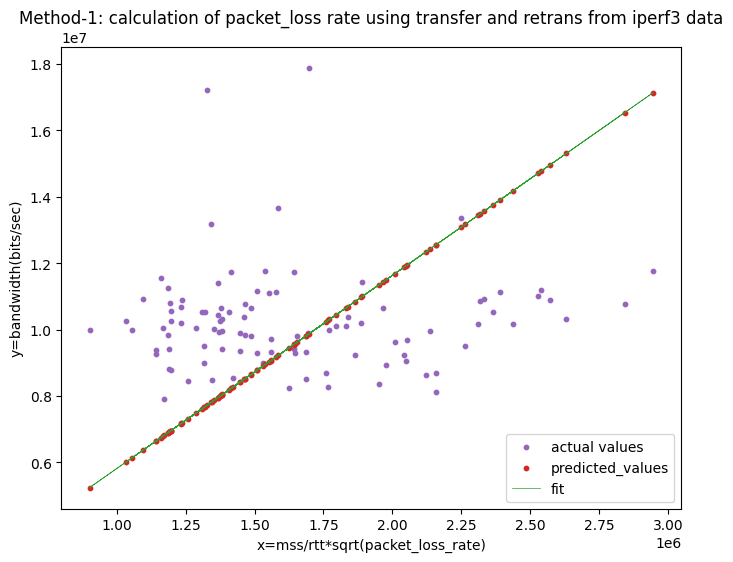

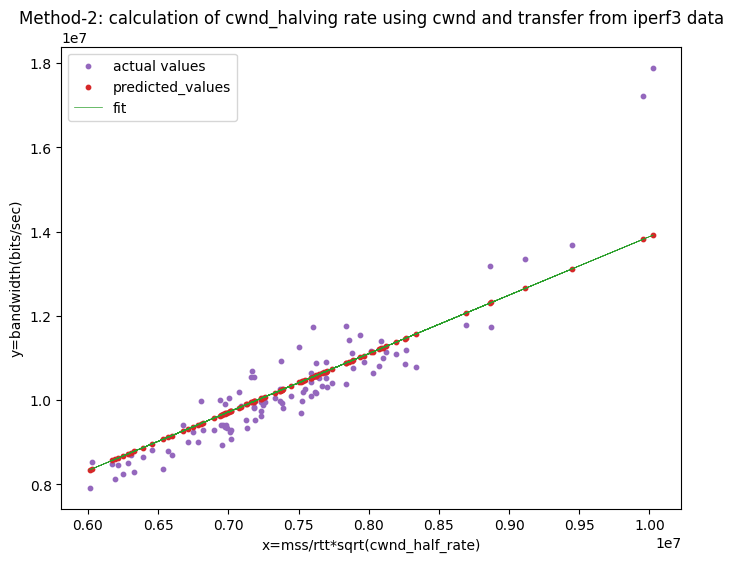

In [18]:
with PdfPages("linear_reg_plot.pdf") as pdf:
  plt.rcParams['figure.figsize'] = (8,6)


  plt.scatter(x=x1_values.squeeze(), y=y_values, color='C4', s=10, label='actual values')
  plt.scatter(x=x1_values.squeeze(), y=y_hat1, color='C3', s=10, label='predicted_values')
  plt.plot(x1_values.squeeze(), y_hat1, color='C2', linewidth=0.5, label='fit')
  plt.xlabel("x=mss/rtt*sqrt(packet_loss_rate)") 
  plt.ylabel("y=bandwidth(bits/sec)")
  plt.title("Method-1: calculation of packet_loss rate using transfer and retrans from iperf3 data")
  plt.legend()
  pdf.savefig()  # saves the current figure into a pdf page
  plt.show()
  plt.close()

  plt.scatter(x=x2_values.squeeze(), y=y_values, color='C4', alpha=1, s=10, label='actual values')
  plt.scatter(x=x2_values.squeeze(), y=y_hat2, color='C3',  alpha=1, s=10, label='predicted_values')
  plt.plot(x2_values.squeeze(), y_hat2, color='C2', linewidth=0.5, label='fit')
  plt.xlabel("x=mss/rtt*sqrt(cwnd_half_rate)")
  plt.ylabel("y=bandwidth(bits/sec)")

  plt.title("Method-2: calculation of cwnd_halving rate using cwnd and transfer from iperf3 data")
  plt.legend()
  pdf.savefig()  # saves the current figure into a pdf page
  plt.show()
  plt.close()

Remove the transfered files after data analysis and/or downloading to your local system.

In [19]:
%rm li*

In [20]:
%rm pac*